In [1]:
!pip install rasterio tensorflow pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 81.5 MB/s eta 0:00:00:00:0100:01


In [2]:
!nvidia-smi

Sat Mar 29 14:17:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8             11W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import pandas as pd

# Load CSV
df = pd.read_csv("/kaggle/input/floods11/splits/flood_handlabeled/flood_train_data.csv")

# Extract correct column (if needed)
if df.shape[1] == 2:  # If there are two columns, extract the first one
    df = df.iloc[:, [0]]  # Keep only the first column

# Rename column to "image_id" for consistency
df.columns = ["image_id"]

# Remove file extensions
df["image_id"] = df["image_id"].str.replace("_S1Hand.tif", "", regex=False)

# Print first few rows
print(df.head())

       image_id
0   Ghana_24858
1  Ghana_147015
2  Ghana_953791
3  Ghana_154838
4  Ghana_134751


In [4]:
import os
import glob

BASE_DIR = "/kaggle/input/floods11/data/flood_events/HandLabeled"
S1_DIR = os.path.join(BASE_DIR, "S1Hand")  # Sentinel-1 images
MASK_DIR = os.path.join(BASE_DIR, "LabelHand")  # Labels

# Find all .tif files recursively
s1_files = glob.glob(os.path.join(S1_DIR, "**/*.tif"), recursive=True)
mask_files = glob.glob(os.path.join(MASK_DIR, "**/*.tif"), recursive=True)

# Extract common IDs by removing suffixes (_S1Hand, _LabelHand)
s1_ids = {os.path.basename(f).replace("_S1Hand.tif", "") for f in s1_files}
mask_ids = {os.path.basename(f).replace("_LabelHand.tif", "") for f in mask_files}

# Print dataset summary
print(f"Found {len(s1_files)} SAR images.")
print(f"Found {len(mask_files)} masks.")

# Identify missing files
missing_s1 = mask_ids - s1_ids  # Masks without SAR images
missing_masks = s1_ids - mask_ids  # SAR images without masks

print(f"\nMissing SAR images: {len(missing_s1)}")
print(f"Missing masks: {len(missing_masks)}")

if missing_s1:
    print("\nExamples of masks without SAR images:", list(missing_s1)[:5])
if missing_masks:
    print("\nExamples of SAR images without masks:", list(missing_masks)[:5])

Found 446 SAR images.
Found 446 masks.

Missing SAR images: 0
Missing masks: 0


In [5]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import os
import tensorflow as tf
import numpy as np
import rasterio
import pandas as pd
import glob

# Paths to dataset folders
BASE_DIR = "/kaggle/input/floods11/data/flood_events/HandLabeled"
S1_DIR = os.path.join(BASE_DIR, "S1Hand")  # Sentinel-1 SAR images
MASK_DIR = os.path.join(BASE_DIR, "LabelHand")  # Flood labels

SPLIT_DIR = "/kaggle/input/floods11/splits/flood_handlabeled"

# Image dimensions
IMG_HEIGHT = 512
IMG_WIDTH = 512

# Load train/test/val splits
def load_split(file):
    df = pd.read_csv(os.path.join(SPLIT_DIR, file), header=None)  # Ensure no incorrect column headers
    df.columns = ["image", "mask"]  # Rename columns for clarity
    return df

train_df = load_split("flood_train_data.csv")
valid_df = load_split("flood_valid_data.csv")
test_df = load_split("flood_test_data.csv")

def load_image_and_mask(image_id, mask_id):  # Now takes 2 arguments
    """Loads Sentinel-1 image and corresponding flood mask."""
    
    image_path = os.path.join(S1_DIR, image_id)
    mask_path = os.path.join(MASK_DIR, mask_id)  # Corrected to use mask_id

    if not os.path.exists(image_path) or not os.path.exists(mask_path):
        print(f"Warning: Missing file {image_path} or {mask_path}")
        return None, None

    # Load SAR image
    with rasterio.open(image_path) as img:
        image = img.read([1, 2])  # Sentinel-1 VH & VV bands
        image = np.stack(image, axis=-1)  # Shape: (H, W, 2)
    
    # ✅ Fix NaN & Inf values
    image = np.nan_to_num(image, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Normalize per-channel (VH, VV)
    min_val = image.min(axis=(0,1))
    max_val = image.max(axis=(0,1))
    image = (image - min_val) / (max_val - min_val + 1e-5)

    # Load mask
    with rasterio.open(mask_path) as mask:
        mask = mask.read(1)  # Single-channel binary mask

    # Resize images & masks
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.image.resize(mask[..., np.newaxis], (IMG_HEIGHT, IMG_WIDTH))
    
    return image, mask

# TensorFlow Dataset Loader
def create_tf_dataset(df, batch_size=8):
    """Creates a TensorFlow Dataset pipeline."""
    image_ids = df["image"].values  
    mask_ids = df["mask"].values

    def generator():
        for image_id, mask_id in zip(image_ids, mask_ids):
            image, mask = load_image_and_mask(image_id, mask_id)
            if image is not None and mask is not None:
                yield image, mask

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, 2), dtype=tf.float32),
            tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, 1), dtype=tf.float32),
        ),
    )

    return dataset.batch(batch_size).shuffle(100).prefetch(tf.data.AUTOTUNE)

# Create TensorFlow datasets
train_dataset = create_tf_dataset(train_df)
valid_dataset = create_tf_dataset(valid_df)
test_dataset = create_tf_dataset(test_df)

# Check dataset
for image, mask in train_dataset.take(1):
    print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")

Image shape: (8, 512, 512, 2), Mask shape: (8, 512, 512, 1)


In [6]:
import pandas as pd

SPLIT_DIR = "/kaggle/input/floods11/splits/flood_handlabeled"

train_df = pd.read_csv(f"{SPLIT_DIR}/flood_train_data.csv")
valid_df = pd.read_csv(f"{SPLIT_DIR}/flood_valid_data.csv")
test_df = pd.read_csv(f"{SPLIT_DIR}/flood_test_data.csv")

print(train_df.head())  # Print first few rows
print(train_df.columns)  # Print column names

   Ghana_103272_S1Hand.tif  Ghana_103272_LabelHand.tif
0   Ghana_24858_S1Hand.tif   Ghana_24858_LabelHand.tif
1  Ghana_147015_S1Hand.tif  Ghana_147015_LabelHand.tif
2  Ghana_953791_S1Hand.tif  Ghana_953791_LabelHand.tif
3  Ghana_154838_S1Hand.tif  Ghana_154838_LabelHand.tif
4  Ghana_134751_S1Hand.tif  Ghana_134751_LabelHand.tif
Index(['Ghana_103272_S1Hand.tif', 'Ghana_103272_LabelHand.tif'], dtype='object')


Using 2 GPUs
Epoch 1/5
     32/Unknown 100s 2s/step - binary_accuracy: 0.9117 - loss: 0.1632 - precision: 0.0333 - recall: 9.7219e-05

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


32/32 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - binary_accuracy: 0.9116 - loss: 0.1625 - precision: 0.0337 - recall: 9.4919e-05 - val_binary_accuracy: 0.8917 - val_loss: 0.0946 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - binary_accuracy: 0.9196 - loss: 0.0899 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_binary_accuracy: 0.8917 - val_loss: 0.0976 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - binary_accuracy: 0.9072 - loss: 0.0844 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_binary_accuracy: 0.8917 - val_loss: 0.1085 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - binary_accuracy: 0.9100 - loss: 0.0887 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_binary_accuracy: 0.8917 - val_loss: 0.0993 - val_precision: 0.0000e+00 - val_

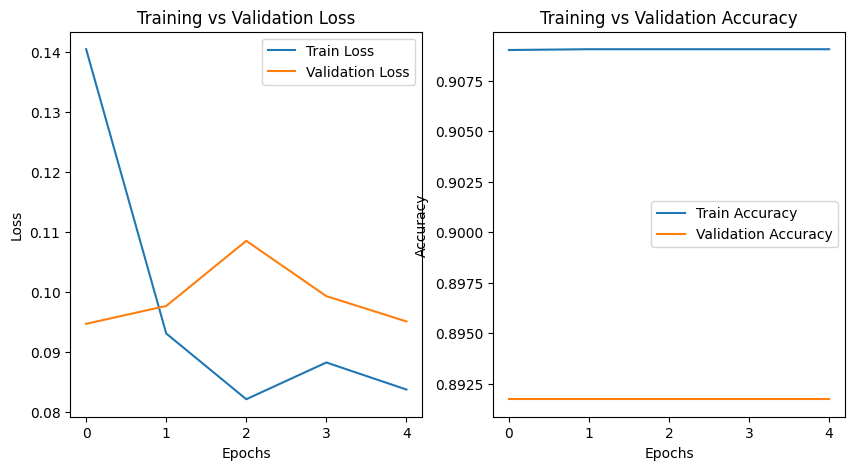

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
F1 Score: 0.0000


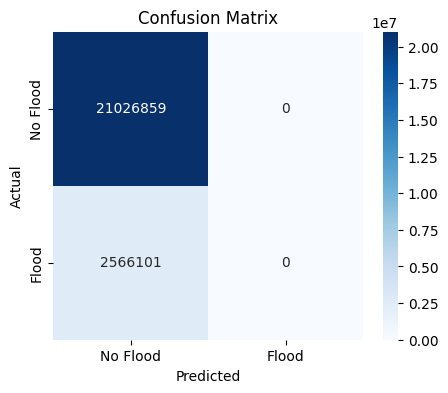

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

# Enable Multi-GPU Training
strategy = tf.distribute.MirroredStrategy()
print(f"Using {strategy.num_replicas_in_sync} GPUs")

# Define Image Size and Channels
IMG_HEIGHT, IMG_WIDTH = 512, 512
INPUT_CHANNELS = 2  # Sentinel-1 has VV and VH bands

# Function to create U-Net model
def unet_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, INPUT_CHANNELS), output_channels=1):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)
    
    # Bridge
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = layers.Dropout(0.5)(conv5)
    
    # Decoder
    up6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(drop5)
    concat6 = layers.Concatenate()([up6, drop4])
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(concat6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
    up7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    concat7 = layers.Concatenate()([up7, conv3])
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(concat7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
    up8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    concat8 = layers.Concatenate()([up8, conv2])
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(concat8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
    up9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    concat9 = layers.Concatenate()([up9, conv1])
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(concat9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
    outputs = layers.Conv2D(output_channels, 1, activation='sigmoid')(conv9)
    
    return models.Model(inputs=inputs, outputs=outputs)


# Preprocess Data
def preprocess_data(image, mask):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize image
    mask = tf.cast(mask, tf.int32)  # Convert mask to integer
    mask = tf.clip_by_value(mask, 0, 1)  # Ensure values are only 0 or 1
    return image, mask

train_dataset = train_dataset.map(preprocess_data)
valid_dataset = valid_dataset.map(preprocess_data)
test_dataset = test_dataset.map(preprocess_data)

# Compute Class Weights
def compute_class_weights(dataset):
    all_labels = np.concatenate([y.numpy().astype(int).ravel() for _, y in dataset])
    all_labels = np.clip(all_labels, 0, 1)
    class_weights = compute_class_weight("balanced", classes=np.unique(all_labels), y=all_labels)
    return {cls: weight for cls, weight in zip(np.unique(all_labels), class_weights)}

# Create U-Net inside Multi-GPU Scope
with strategy.scope():
    unet = unet_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, INPUT_CHANNELS))
    class_weights_dict = compute_class_weights(train_dataset)

    unet.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.BinaryFocalCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
    )

# Training function
def train_model(model, train_dataset, valid_dataset, epochs=5):
    callbacks = [
        ModelCheckpoint("unet_flood_best.keras", monitor="val_loss", save_best_only=True, mode="min"),
        EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6)
    ]
    
    history = model.fit(train_dataset, validation_data=valid_dataset, epochs=epochs, callbacks=callbacks)
    return history

# Train the model
unet_history = train_model(unet, train_dataset, valid_dataset)

# Plot Training & Validation Loss
def plot_training_history(history):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['binary_accuracy'], label="Train Accuracy")
    plt.plot(history.history['val_binary_accuracy'], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    
    plt.show()

plot_training_history(unet_history)

# Compute Confusion Matrix & F1 Score
def compute_metrics(model, test_dataset):
    y_true, y_pred = [], []
    
    for image, mask in test_dataset:
        pred_mask = model.predict(image) > 0.5
        y_true.append(mask.numpy().flatten())
        y_pred.append(pred_mask.flatten())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    
    cm = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"F1 Score: {f1:.4f}")

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Flood", "Flood"], yticklabels=["No Flood", "Flood"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

compute_metrics(unet, test_dataset)